<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/6_deep_learning_parte1_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning 1

![texto del vínculo](https://www.ait.de/wp-content/uploads/2022/01/Vergleich-Machine-Learning-Deep-Learning-1024x768.png)

Deep learning es un tipo de aprendizaje de máquinas en donde las predicciones se realizan a través de una serie de operaciones matriciales concatenadas. Uno de los elementos más importantes en el Deep Learning es la casi nula ingeniería de características. En el ejemplo que veremos ahora, se utiliza un conjunto de imágenes segmentadas para realizar el entrenamiento de un modelo de segmentación automática de núcleos celulares, este entrenamiento simplemente se realiza con los pixeles crudos de las imágenes, sin ingeniería de características.

In [1]:
import tensorflow as tf # Biblioteca de redes neuronales
import pandas as pd # # Biblioteca de manejo de conjuntos de datos
import sklearn.preprocessing # Preprocesamiento de datos
import sklearn.model_selection # # Funciones para preparar nuestro conjunto de datos
import sklearn.metrics # Métricas
import matplotlib.pyplot as plt # Biblioteca de visualización
import numpy as np # Biblioteca de álgebra lineal
import scipy.stats
import os
import PIL
import datetime

## Red fully connected

Utilizaremos un conjunto de datos que relaciones características fisiológicas extraídas a través de un dispositivo vestible con tipos de actividades que los sujetos estaban realizando en ese momento.

El conjunto de datos es del artículo Activity Recognition Using Wearable Physiological Measurements: Selection of Features from a Comprehensive Literature Study https://pubmed.ncbi.nlm.nih.gov/31847261/

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/activity_recognition.csv")
data.head()

,ecg_original_mean,ecg_original_std,ecg_original_trimmean25,ecg_original_median,ecg_original_skewness,ecg_original_kurtosis,ecg_original_max,ecg_original_min,ecg_original_prctile25,ecg_original_prctile75,...,eda_functionals_power_filt2kurtosis_1,eda_functionals_power_filt2max_1,eda_functionals_power_filt2min_1,eda_functionals_power_filt2prctile25_1,eda_functionals_power_filt2prctile75_1,eda_functionals_power_filt2geomean(abs)_1,eda_functionals_power_filt2harmmean_1,eda_functionals_power_filt2mad_1,eda_functionals_power_filt2baseline_1,activity
0,0.022200,0.278189,0.047467,0.067892,-0.734477,3.62217,0.838892,-1.442110,-0.136108,0.220892,...,1015.81,585451000.0,0.006724,2.43873,15.87360,7.39725,1.264500,1152950.0,601642.0,neutral
1,-0.001098,0.210017,-0.048560,-0.090702,2.137990,8.33018,1.244300,-0.290702,-0.127702,0.048299,...,1016.41,791163000.0,0.014209,4.13302,25.89920,12.76960,2.771000,1556760.0,455372.0,mental
2,0.004552,0.148971,-0.004151,0.014918,0.400160,2.78112,0.516918,-0.386082,-0.126082,0.100918,...,1015.65,76208300.0,0.003753,1.25774,8.42661,4.03412,0.753581,150121.0,76244.4,mental
3,-0.005813,0.206158,0.005190,0.001100,-0.643985,4.62722,0.549100,-1.126900,-0.116900,0.131100,...,1015.62,184945000.0,0.005781,1.96623,12.63830,6.26733,1.331560,364353.0,2322520.0,emotional
4,0.000940,0.073076,-0.008041,-0.012362,1.275040,5.41514,0.400638,-0.147362,-0.047362,0.033638,...,1015.65,374871000.0,0.007874,2.58581,16.30720,7.85350,1.638010,738448.0,2142830.0,neutral


El conjunto de datos cuenta con **533 características** de mediciones de Electrocardiograma (ECG), Bioimpedancia Eléctrica Torácica (TEB) y la Actividad Ectodérmica (EDA) for activity recognition.

In [3]:
#Dividir label de los datos
features = data.iloc[:,:-1]
label = data.activity

#Normalización de los datos
scaler = sklearn.preprocessing.MinMaxScaler()
features_scaled = scaler.fit_transform(features)

np.unique(label).tolist()

['emotional', 'mental', 'neutral', 'physical']

Nuestras etiquetas son discretas, por lo que las transformamos con un codificador One-Hot

In [4]:
encoder = sklearn.preprocessing.LabelEncoder() # Label encoder de sklearn que mapea las categorías a números enteros
label_encoded = encoder.fit_transform(label)
label_encoded = tf.keras.utils.to_categorical(label_encoded) # Implementación de Tensorflow del One-Hot Encoding

Separamos el conjunto de datos en un subconjunto de entrenamiento, validación y prueba.

In [5]:
features_train, features_test, label_train, label_test = sklearn.model_selection.train_test_split(
    features_scaled,
    label_encoded,
    random_state=11
)
features_train, features_val, label_train, label_val = sklearn.model_selection.train_test_split(
    features_train,
    label_train,
    test_size=0.1,
    random_state=11
)

Diseñamos la arquitectura de nuestra red neuronal.
![texto del vínculo](https://www.researchgate.net/publication/355067832/figure/fig4/AS:11431281125422892@1678294386643/Illustration-of-the-structure-of-fully-connected-layers-and-softmax-layer.png)

In [6]:
model_0 = tf.keras.Sequential([ # Este objeto recibe una lista de capas.
    tf.keras.layers.Dense(128, activation='relu'), # Capa densa de 128 neuronas con una activación ReLU
    tf.keras.layers.Dense(len(encoder.classes_), activation='softmax') # Capa densa de clasificación
                                                                       # con una activación Softmax
                                                                       # la cantidad de neuronas de esta capa
                                                                       # debe ser igual a la cantidad de clases
])

Configuramos el modelo para el entrenamiento

In [7]:
model_0.compile(optimizer='adam', # Utilizamos un optimizador ADAM
              loss='categorical_crossentropy', # Usamos entropía cruzada categórica porque nuestro problema es de clasificación de más de 2 clases
              metrics=['accuracy']) # Medimos el rendimiento del modelo con la exactitud

Ajustamos el modelo

In [8]:
history_0 = model_0.fit( # Guardamos el historial del modelo
          features_scaled,
          label_encoded,
          epochs=10, # Detenemos el entrenamiento al llegar a 10 épocas
          validation_data=(features_val,label_val) # Al final de cada época probamos el rendimiento en el conjunto de validación
          )

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5904 - loss: 0.9681 - val_accuracy: 0.7411 - val_loss: 0.5716
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7563 - loss: 0.5573 - val_accuracy: 0.7946 - val_loss: 0.4936
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7733 - loss: 0.4942 - val_accuracy: 0.7976 - val_loss: 0.4665
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7920 - loss: 0.4607 - val_accuracy: 0.7917 - val_loss: 0.4456
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8025 - loss: 0.4483 - val_accuracy: 0.8155 - val_loss: 0.4235
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8174 - loss: 0.4301 - val_accuracy: 0.7887 - val_loss: 0.4393
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7997 - loss: 0.4235 - val_accuracy: 0.8214 - val_loss: 0.3910
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8266 - loss: 0.4000 - val_accuracy: 0.

Visualizamos el rendimiento de nuestro modelo al avanzar las épocas.

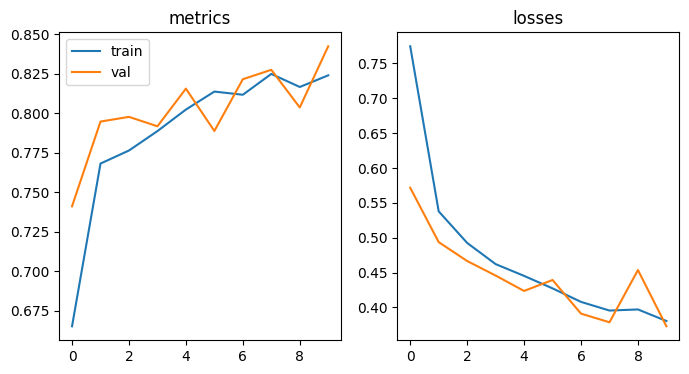

In [9]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].plot(history_0.history["accuracy"],label="train")
axs[0].plot(history_0.history["val_accuracy"],label="val")
axs[0].set_title("metrics")

axs[1].plot(history_0.history["loss"])
axs[1].plot(history_0.history["val_loss"])
axs[1].set_title("losses")
axs[0].legend()
plt.show()

Verificamos el rendimiento en el conjunto de prueba

In [10]:
predictions = model_0.predict(features_test)
print(sklearn.metrics.classification_report(
    label_test.argmax(axis=1), # Utilizamos argmax para obtener la etiqueta de cada punto de datos
    predictions.argmax(axis=1)
))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
              precision    recall  f1-score   support

           0       0.70      0.82      0.76       267
           1       0.77      0.72      0.74       292
           2       0.97      0.90      0.94       297
           3       1.00      0.98      0.99       264

    accuracy                           0.85      1120
   macro avg       0.86      0.86      0.86      1120
weighted avg       0.86      0.85      0.86      1120



¿Cómo se ve el cálculo matemático?

>  FC = $ReLU(X · 𝐖_{fc} + B_{fc})$

<img  src="https://jalammar.github.io/images/NNs_2_variables.png" width="500" height="300"></img>

<img  src="https://jalammar.github.io/images/NNs_formula_two_variables.png" width="500" height="150"></img>





> Prediction = $Softmax(FC · 𝐖_{o} + B_{o})$



In [11]:
prediction = tf.nn.softmax(
  tf.tensordot(
    tf.nn.relu(
      tf.tensordot(
        features_test.astype(np.float32), #Valores de test
        model_0.layers[0].get_weights()[0], #Producto punto con pesos
        1
      )  + model_0.layers[0].get_weights()[1] #Añadir Bias
    ),                                    #Función de activación Relu
    model_0.layers[1].get_weights()[0],     #Producto punto con pesos capa final
    1
  ) + model_0.layers[1].get_weights()[1]    #Añadir Bias capa Final
)                                         #Softmax
prediction

<tf.Tensor: shape=(1120, 4), dtype=float32, numpy=
array([[3.2366809e-01, 4.5947847e-01, 2.1684487e-01, 8.5306056e-06],
       [7.6458044e-02, 9.1816002e-01, 4.6460466e-03, 7.3582045e-04],
       [1.9747442e-04, 1.7630431e-04, 7.0357594e-08, 9.9962622e-01],
       ...,
       [4.5706522e-01, 5.3738546e-01, 5.1712659e-03, 3.7799278e-04],
       [2.3378012e-05, 1.8779593e-04, 2.8057962e-06, 9.9978614e-01],
       [2.1624556e-01, 7.4452728e-01, 3.8854025e-02, 3.7313209e-04]],
      dtype=float32)>

In [12]:
prediction_pos = np.argmax(prediction, axis=1)
comparison = np.equal(prediction_pos,np.argmax(label_test))
print(f"Comparación con test:  {comparison} \n")
print(f"Resultados correctamente clasificados {np.sum(comparison)} de un total de {label_test.shape[0]}")

Comparación con test:  [False False False ... False False False] 

Resultados correctamente clasificados 311 de un total de 1120


### Actividad 1

Aumenta la cantidad de épocas y describe cómo se comportan las métricas al aumentar la cantidad de épocas.

In [ ]:
#Prográmame

### Actividad 2

Añada una capa de dimesión 256 al modelo (como primera capa) y compare con la actividad 1

In [ ]:
#Prográmame

Referencias:

- [tensorflow.nn](https://www.tensorflow.org/api_docs/python/tf/nn)

- [Modelo de keras](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

- [Capas de keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer#get_weights)

## Red convolucional

Exploraremos cómo se realizan las transformaciones de los datos al transitar por una red convolucional.

In [29]:
def nice_image_printer(model, image):
    """prints the cat as a 2d array"""
    image_batch = np.expand_dims(image,axis=0)
    conv_image2 = model.predict(image_batch)

    conv_image2 = np.squeeze(conv_image2, axis=0)
    conv_image2 = conv_image2.reshape(conv_image2.shape[:2])

    plt.imshow(conv_image2 , cmap="copper")
    plt.colorbar()

def gkern(kernlen=[21,21], nsig=[3, 3]):
    """Returns a 2D Gaussian kernel array."""

    assert len(nsig) == 2
    assert len(kernlen) == 2
    kern1d = []
    for i in range(2):
        interval = (2*nsig[i]+1.)/(kernlen[i])
        x = np.linspace(-nsig[i]-interval/2., nsig[i]+interval/2., kernlen[i]+1)
        kern1d.append(np.diff(scipy.stats.norm.cdf(x)))

    kernel_raw = np.sqrt(np.outer(kern1d[0], kern1d[1]))
    kernel = kernel_raw/kernel_raw.sum()
    return kernel

def kernel_init(shape, dtype=None, partition_info=None):
    """Kernel initializer"""
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = gkern([shape[0], shape[1]])
    return kernel

Cargamos y preprocesamos nuestro conjunto de datos.

In [14]:
!wget -q https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/cat.png

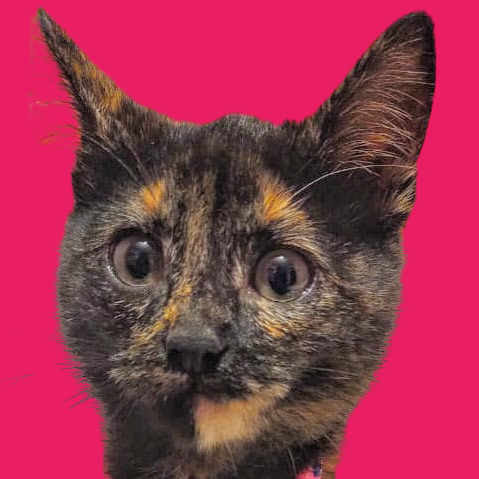

In [15]:
cat = tf.keras.preprocessing.image.load_img("cat.png") # Importamos la imagen
cat # Visualizamos la imagen

In [16]:
cat_array = tf.keras.preprocessing.image.img_to_array(cat) / 255 # Transformamos la imagen en un arreglo y lo normalizamos entre 0 y 1.
cat_array.shape # Estas son las dimensiones de nuestra imagen (largo, ancho, canales)

(479, 479, 3)

Instanciamos nuestro primer modelo con una capa única de convolución.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


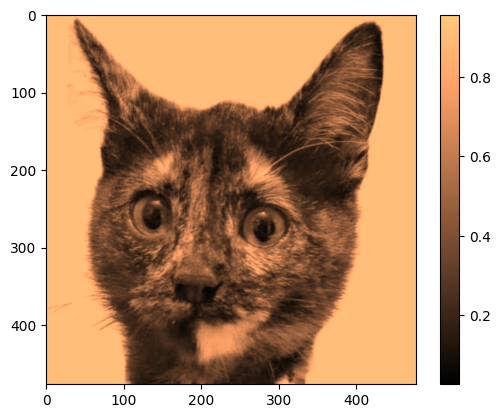

In [30]:
cat_model_1 = tf.keras.Sequential([
  tf.keras.layers.Conv2D( # Capa convolucional
      filters = 1, # Sólo utilizaremos 1 kernel
      kernel_size = (3,3), # Estas son las dimensiones del kernel
      input_shape = cat_array.shape, # Estas son las dimensiones de entrada de la red.
      kernel_initializer = kernel_init # Utilizamos un kernel gausiano que lo generamos con nuestro inicializador
  )
])
nice_image_printer(cat_model_1, cat_array)

Aumentamos el tamaño del kernel.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


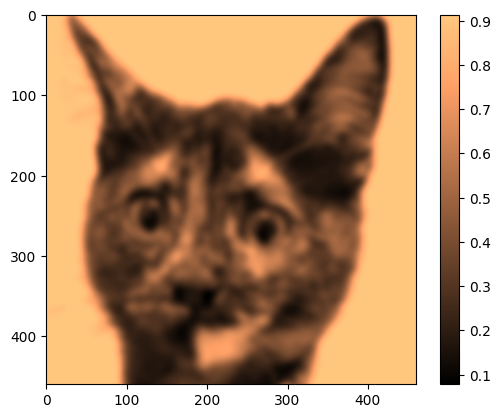

In [31]:
cat_model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (20,20), # Ahora el kernel es de 15*15
      input_shape = cat_array.shape,
      kernel_initializer = kernel_init
  )
])
nice_image_printer(cat_model_2, cat_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


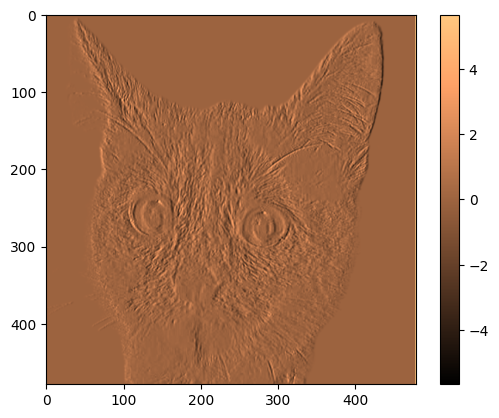

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


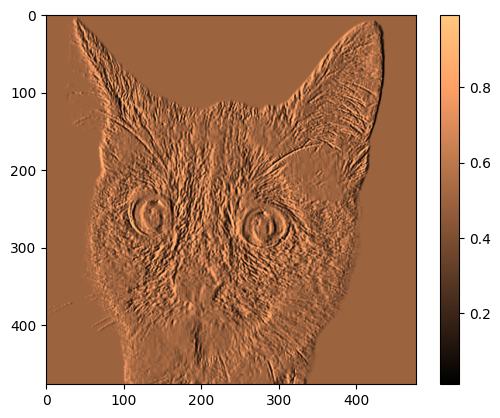

In [32]:
# Filtro Sobel 3x3
kernel = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
], dtype=np.float32)

# Expande a 3 canales (RGB, por ejemplo), y a 1 filtro de salida
kernel = np.stack([kernel, kernel, kernel], axis=-1)  # (3, 3, 3)
kernel = np.expand_dims(kernel, axis=-1)              # (3, 3, 3, 1)

input_shape = cat_array.shape  # (alto, ancho, canales)

cat_model_3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(3, 3),
        input_shape=input_shape,
        padding='same',
        use_bias=False,
        kernel_initializer = kernel_init
    )
])
# Se asignan los pesos a la capa
cat_model_3.set_weights([kernel])

cat_model_4 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = input_shape,
      activation = "sigmoid",
      use_bias=False,
      kernel_initializer = kernel_init
  ),
])
# Se asignan los pesos a la capa
cat_model_4.set_weights([kernel])

nice_image_printer(cat_model_3, cat_array)
plt.show()
nice_image_printer(cat_model_4, cat_array)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


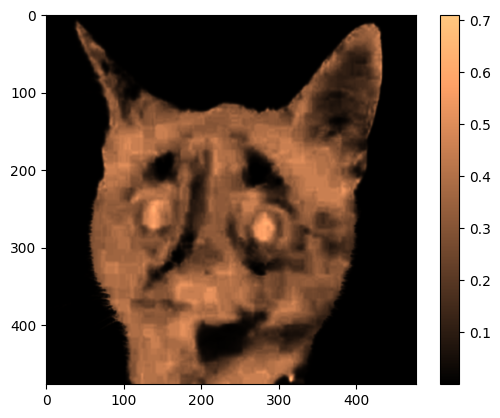

In [33]:
#Cambiar pesos del kernel
kernel = np.array(
    [
     [-1,0,1],
     [-2,0,2],
     [-1,0,1]
    ])
kernel = np.expand_dims(np.stack([kernel,kernel,kernel]), axis=-1)

cat_model_5 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init,
      use_bias=False
  ),
])

cat_model_5.layers[0].set_weights([kernel])
nice_image_printer(cat_model_5, cat_array)

Agregamos una función de activación y max pooling.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


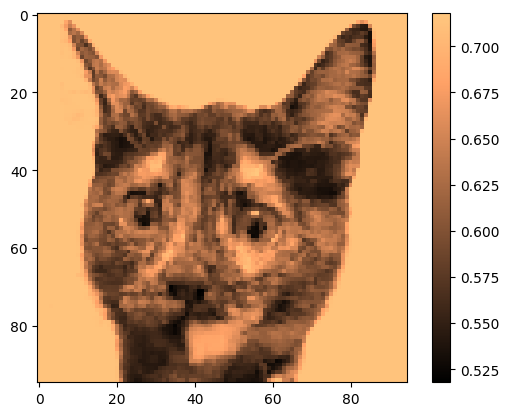

In [21]:
cat_model_6 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(
      filters = 1,
      kernel_size = (3,3),
      input_shape = cat_array.shape,
      activation = "sigmoid",
      kernel_initializer = kernel_init
  ),
  tf.keras.layers.MaxPool2D(
      pool_size = (5,5)
  )
])

nice_image_printer(cat_model_6, cat_array)

### Actividad 3

Cree un kernel que destaque todos los bordes (arriba, abajo, izquierda y derecha) y reduzca la dimensión de la imágen en una 3ra parte utilizando Maxpooling. Utilize la función de activación `sigmoid` para comparar con los resultados anteriores.


In [ ]:
#Prográmame

## Clasificación de radiografías de tórax

Para este notebook se utilizaron los datos de https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5 y código de https://www.kaggle.com/sanwal092/intro-to-cnn-using-keras-to-predict-pneumonia

In [ ]:
# Obtenemos el conjunto de datos desde el servidor de SASIBA.
!gdown 1JXOpOKfnItGOIc_Ua-NqScIGjwAlcql- -O chest_xray.rar

Downloading...
From: https://drive.google.com/uc?id=1JXOpOKfnItGOIc_Ua-NqScIGjwAlcql-
To: /content/chest_xray.rar
100% 1.13G/1.13G [00:19<00:00, 57.9MB/s]


In [ ]:
# Descomprimimos el conjunto de datos.
!unrar x chest_xray.rar -idq

In [ ]:
# Configuramos las rutas de los datos
train_folder= 'chest_xray/train/'
val_folder = 'chest_xray/val/'
test_folder = 'chest_xray/test/'
train_n = train_folder+'NORMAL/'
train_p = train_folder+'PNEUMONIA/'

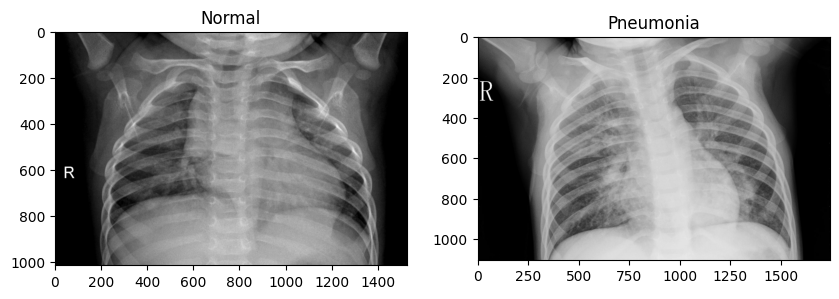

In [ ]:
# Miramos un par de radiografías normales y patólogicas al azar

rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]

norm_pic_address = train_n+norm_pic

rand_p = np.random.randint(0,len(os.listdir(train_p)))

sic_pic =  os.listdir(train_p)[rand_norm]
sic_address = train_p+sic_pic

norm_load = PIL.Image.open(norm_pic_address)
sic_load = PIL.Image.open(sic_address)

f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap="gray")
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap="gray")
a2.set_title('Pneumonia')

plt.show()

In [ ]:
# Configuramos el generador de datos que utilizará nuestra red

batch_size = 32

# Queremos aumentar los datos del conjunto de prueba al generar imágenes sintéticas distorisionadas
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, # A las imágenes se les normaliza el brillo
                                   #shear_range = 0.2, # Distorsionamos las imágenes
                                   #zoom_range = 0.2, # Acercamos las imágenes
                                   #horizontal_flip = True
                                   ) # Volteamos horizontalmente las imágenes

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(train_folder,
                                                 target_size = (64, 64), # Las imágenes se redimensionan a 64*64
                                                 batch_size = batch_size,
                                                 class_mode = 'binary',
                                                 color_mode="grayscale") # Sólo utilizamos el canal de brillo

val_set = test_datagen.flow_from_directory(val_folder,
                                            target_size=(64, 64),
                                            batch_size=batch_size,
                                            class_mode='binary',
                                            shuffle = False,
                                            color_mode="grayscale")

test_set = test_datagen.flow_from_directory(test_folder,
                                            target_size = (64, 64),
                                            batch_size = batch_size,
                                            class_mode = 'binary',
                                            shuffle = False,
                                            color_mode="grayscale")

Found 4186 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Construimos la arquitectura de la red neuronal

cnn = tf.keras.Sequential()

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(64, 64, 1))) # Capa de convolución

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))

cnn.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(activation = 'relu', units = 128))
cnn.add(tf.keras.layers.Dense(activation = 'sigmoid', units = 1))

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy']) # Creamos la arquitectura

In [ ]:
# Verificamos la arquitectura

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 128)               8

In [ ]:
# Entrenamos la red neuronal
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

cnn_history = cnn.fit(training_set,
                         epochs = 10, # Entrenamos la red por 10 épocas
                         validation_data = val_set,
                        callbacks=callback)

Epoch 1/10
131/131 [==============================] - 42s 309ms/step - loss: 0.3331 - accuracy: 0.8526 - val_loss: 0.4523 - val_accuracy: 0.8125
Epoch 2/10
131/131 [==============================] - 40s 308ms/step - loss: 0.1279 - accuracy: 0.9508 - val_loss: 0.5273 - val_accuracy: 0.6875
Epoch 3/10
131/131 [==============================] - 41s 310ms/step - loss: 0.1113 - accuracy: 0.9568 - val_loss: 0.1762 - val_accuracy: 0.9375
Epoch 4/10
131/131 [==============================] - 40s 309ms/step - loss: 0.0938 - accuracy: 0.9654 - val_loss: 0.9615 - val_accuracy: 0.6250
Epoch 5/10
131/131 [==============================] - 43s 328ms/step - loss: 0.0921 - accuracy: 0.9656 - val_loss: 0.1764 - val_accuracy: 0.9375
Epoch 6/10
131/131 [==============================] - 43s 326ms/step - loss: 0.0786 - accuracy: 0.9713 - val_loss: 0.2078 - val_accuracy: 0.9375


In [ ]:
predictions = cnn.predict(test_set, verbose = 1) > 0.5 # Predecimos sobre el conjunto de prueba

20/20 [==============================] - 5s 212ms/step


In [ ]:
sklearn.metrics.confusion_matrix(test_set.classes, predictions) # Matriz de confusión

array([[ 94, 140],
       [  7, 383]])

In [ ]:
print(sklearn.metrics.classification_report(test_set.classes, predictions)) # Resumen del rendimiento del modelo

              precision    recall  f1-score   support

           0       0.93      0.40      0.56       234
           1       0.73      0.98      0.84       390

    accuracy                           0.76       624
   macro avg       0.83      0.69      0.70       624
weighted avg       0.81      0.76      0.73       624



### Exploración

Para entender cómo funciona la red neuronal, visualizaremos las salidas de cada una de las capas.

In [ ]:
def image_loader(path):
  image_location = path # Seleccionamos una imagen del conjunto de prueba
  img = PIL.Image.open(image_location)
  # Cargamos la imagen
  img_resized = tf.keras.preprocessing.image.load_img(
      image_location,
      target_size = (64, 64), # Debemos redimensionar la imagen para poder ser ingresada a la red
      color_mode="grayscale"
  )
  # Transformamos la imagen en un arreglo de las dimensiones que recibe la red
  img_array = tf.keras.preprocessing.image.img_to_array(
      img_resized
  )
  img_array = np.expand_dims(
      img_array,
      axis=0
  )
  return img, img_resized, img_array

def get_activations(model,img_array):
  # Creamos un modelo que entrega los resultados después de cada capa
  layer_outputs = [layer.output for layer in model.layers]
  layer_names = [layer.name for layer in model.layers]
  activation_model = tf.keras.models.Model(inputs=model.layers[0].input, outputs=layer_outputs)
  activations = activation_model.predict(img_array)
  activations = list(zip(layer_names,activations))
  return activations

# Esta función grafica los resultados de los filtros de la capa de convolución
def plot_conv_layer_result(activations,j):
  fig, axs = plt.subplots(
      nrows=4,
      ncols=8,
      figsize=(15,8)
  )
  fig.suptitle(activations[j][0])
  for i,ax in enumerate(axs.ravel()):
      ax.imshow(activations[j][1][0,:,:,i], cmap="viridis")
      ax.axis("off")
  plt.show()

# Con esto graficamos los arreglos unidimensionales
def plot_1d_layer_result(activations,j):
  values = activations[j][1][0,:]
  plt.bar(
      range(len(values)),
      values
  )
  plt.title(activations[j][0])
  plt.show()

#### Radiografía de pneumonia

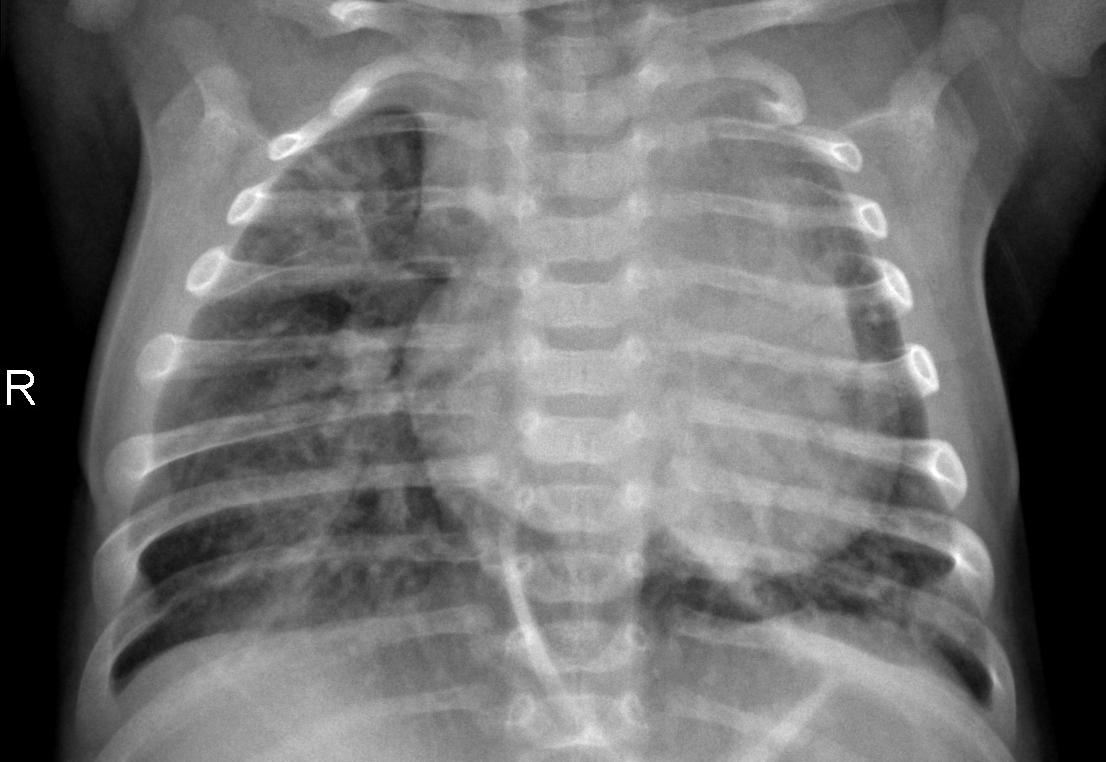

In [ ]:
pneumonia_img, pneumonia_img_resized, pneumonia_img_array = image_loader("chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
pneumonia_img

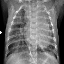

In [ ]:
pneumonia_img_resized

In [ ]:
# Predecimos sobre el arreglo
pneumonia_activations = get_activations(cnn,pneumonia_img_array)
cnn.predict(pneumonia_img_array)

1/1 [==============================] - 0s 19ms/step


array([[1.]], dtype=float32)

En el siguiente gráfico vemos las 32 imágenes correspondientes a la salida de cada uno de los filtros de la capa de convolución.

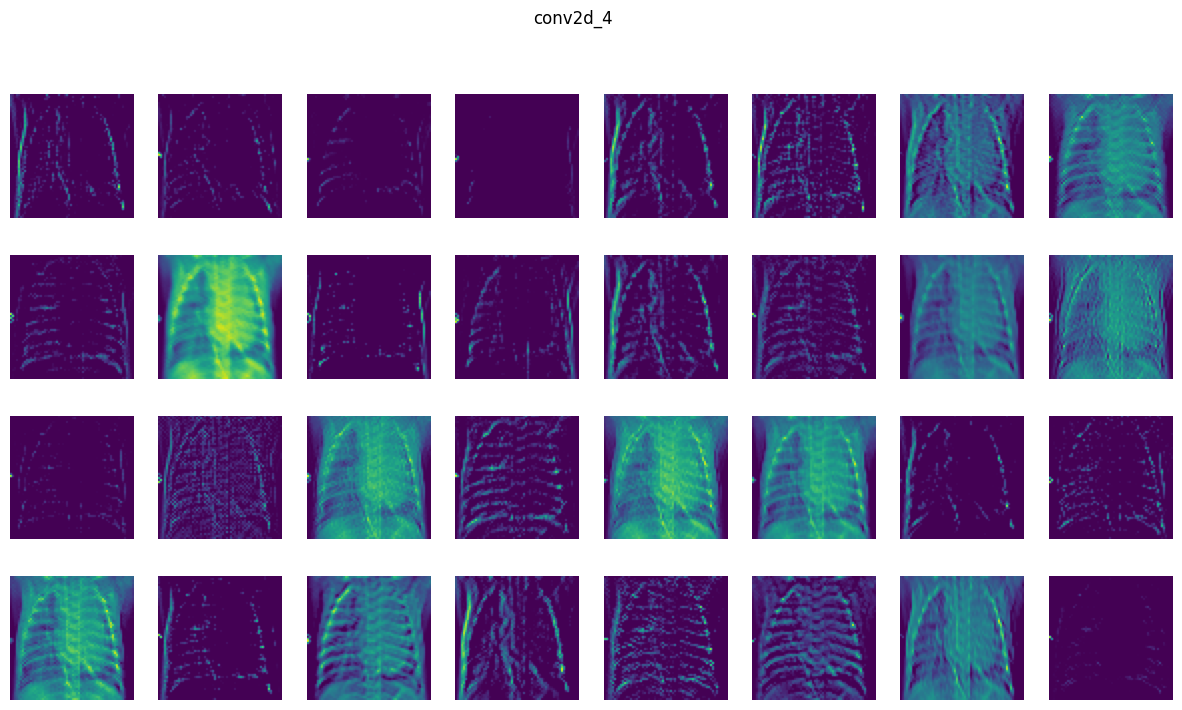

In [ ]:
plot_conv_layer_result(pneumonia_activations,0)

Vemos que sucede en la segúnda capa de covolución




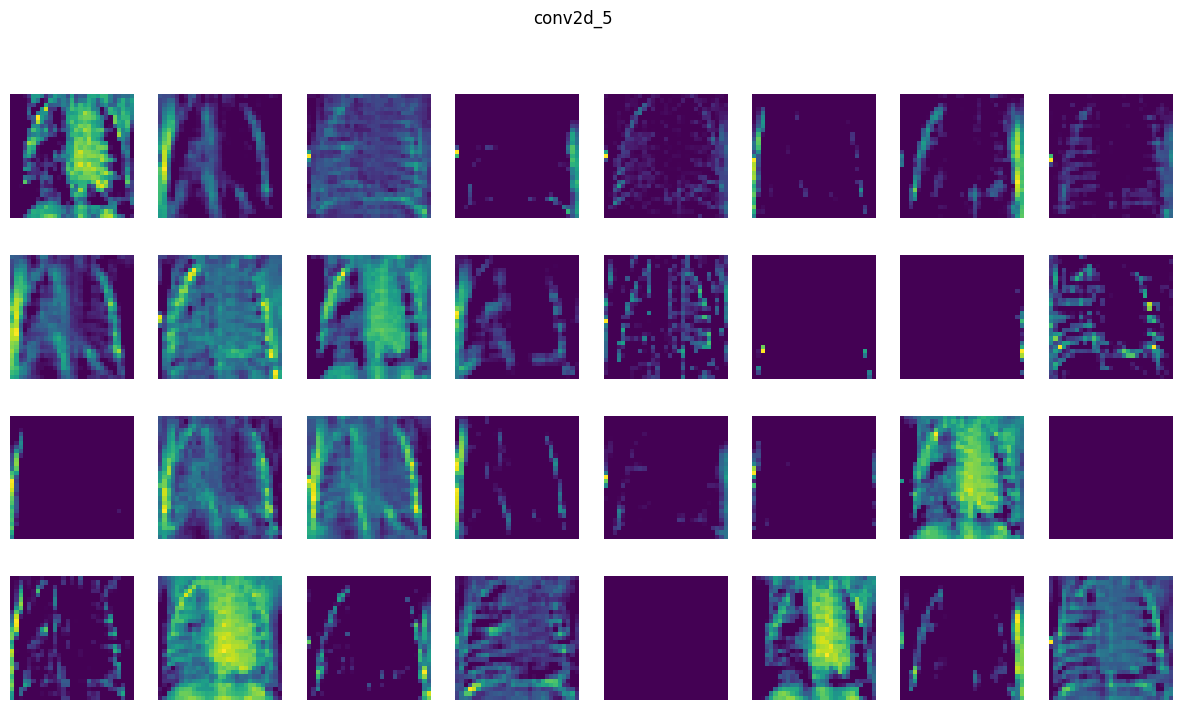

In [ ]:
plot_conv_layer_result(pneumonia_activations,2)

### Actividad 4

Modifica la arquitectura agregando una nueva capa de convolución y max-pooling prueba, si mejoran las métricas y visualiza las salidas de las capas.

In [ ]:
#Prográmame